In [55]:
import networkx as nx
import numpy as np
import scipy
from scipy.io import mmread
import scipy.stats as st
import matplotlib.pyplot as plt
import itertools
import os
import random

## Utils

In [95]:
def giant_component(G):
    Gcc = sorted(nx.connected_components(G), key = len, reverse = True)
    G0 = G.subgraph(Gcc[0])
    return G0
def connectivity_perc(G):
    """How many nodes are in the giant component"""
    G0 = giant_component(G)
    connectivity_perc = G0.number_of_nodes() / G.number_of_nodes()  
    return connectivity_perc

def average_clustering(G):
    return np.mean(list(nx.clustering(G).values()))
def average_degree(G):
    return sum(G.degree(n) for n in G.nodes) / len(G.nodes)

def average_shortest_path_length_sampled(G, n_samples=500):
    G0 = giant_component(G)
    if n_samples >= len(G0.nodes):
        return nx.average_shortest_path_length(G0)
    
    idxs = np.random.choice(len(G0.edges), n_samples, replace = False)
    edges = np.array(G0.edges)[idxs]
                     
    lengths = []
    for u, v in edges:
        length = nx.shortest_path_length(G0, source=u, target=v)
        lengths.append(length)
    return np.mean(length)


def print_stats(G, n_samples = 500):
    print(f"{G.number_of_nodes() = :}")
    print(f"{G.number_of_edges() = }")
    print(f"{average_degree(G) = :.2f}")
    print(f"{average_clustering(G) = :.2f}")
    print(f"{connectivity_perc(G) = :.2f}")
    print(f"{average_shortest_path_length_sampled(G, n_samples) = }") 
    

In [103]:
G_pgrid = nx.from_scipy_sparse_matrix(mmread(os.path.join('..', 'data', 'power-US-Grid.mtx')))
G_arvix =nx.read_edgelist(os.path.join('..', 'data', 'collaboration_network_of_arxiv_general_relativity_category.txt'), create_using=nx.Graph)
G_fb = nx.read_edgelist(os.path.join('..', 'data', 'facebook_combined.txt'), create_using=nx.Graph)
G_wiki = nx.read_edgelist(os.path.join('..', 'data', 'wiki_vote.txt'), create_using=nx.Graph)


# Power law distribution

Probability density function:
$$f(x, a) = ax^{a-1}$$
for $0 \leq x \leq 1, a > 0$. $a$ is a shape parameter

In [118]:
a = .66
mean, var = st.powerlaw.stats(a, moments='mv')
print(f"{mean = }")
print(f"{var = }")

mean = array(0.39759036)
var = array(0.09004221)


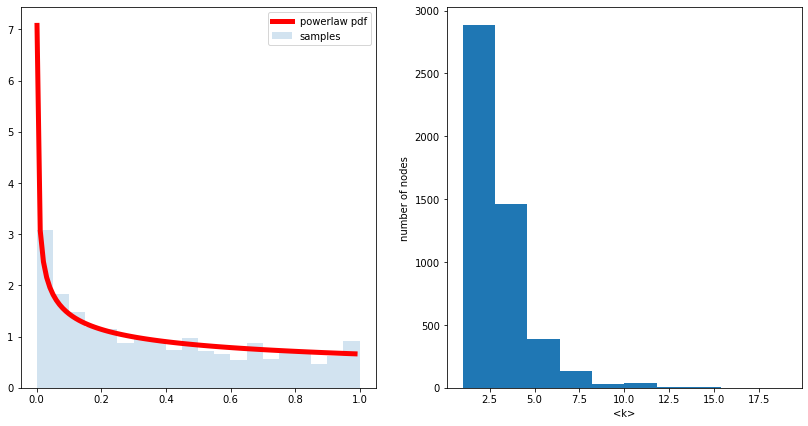

In [119]:
x = np.linspace(st.powerlaw.ppf(.01, a), st.powerlaw.ppf(.99, a), 100)
y = st.powerlaw.pdf(x, a)

plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'r-', lw = 5, label = 'powerlaw pdf')

samples = [st.powerlaw(a).rvs() for _ in range(1000)]
plt.hist(samples, density = True, alpha = .2, label = 'samples', bins = 20)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist([G_pgrid.degree(n) for n in G_pgrid.nodes], label = 'Real node distrib')
plt.xlabel('<k>')
plt.ylabel('number of nodes')
plt.show()

# Small world

Can we have high clustering while also having short paths?

*Intuition*
It states that if you choose any two individuals anywhere on Earth, you will find a path of at most six acquaintances between them

### Distances in small worlds
For a random network:
- we find $\langle k \rangle$ nodes at distance 1
- we find $\langle k \rangle^2$ nodes at distance 2
- we find $\langle k \rangle^d$ nodes at distance d
- Summing we get $N(d) = \sum_0^d \langle k \rangle ^d$

$\boxed{d_{max} \approx \dfrac {\log N} {\log \langle k \rangle}} \Rightarrow$ Distance rises way slower than the number of nodes -- **Small world phenomena**

In [20]:
print(G_fb)

Graph with 4039 nodes and 88234 edges


In [17]:
k_fb = average_degree(G_fb)
d_fb = nx.average_shortest_path_length(G_fb)

In [19]:
print(d_fb)
print(np.log(G_fb.number_of_nodes()) / np.log(k_fb))

3.6925068496963913
2.198421846915431


## Watts-Storgatz model

**Construction**  
1. Start: We start from a ring of nodes, each node being connected to their immediate and next neighbors $\to$ each node has $\langle C_i \rangle = \dfrac 3 4$ for $p = 0$.  
2. Rewiring phase: with probability $p$ cut a side and link it to another node

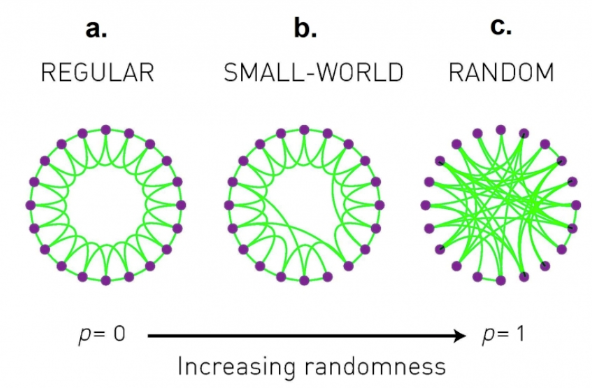

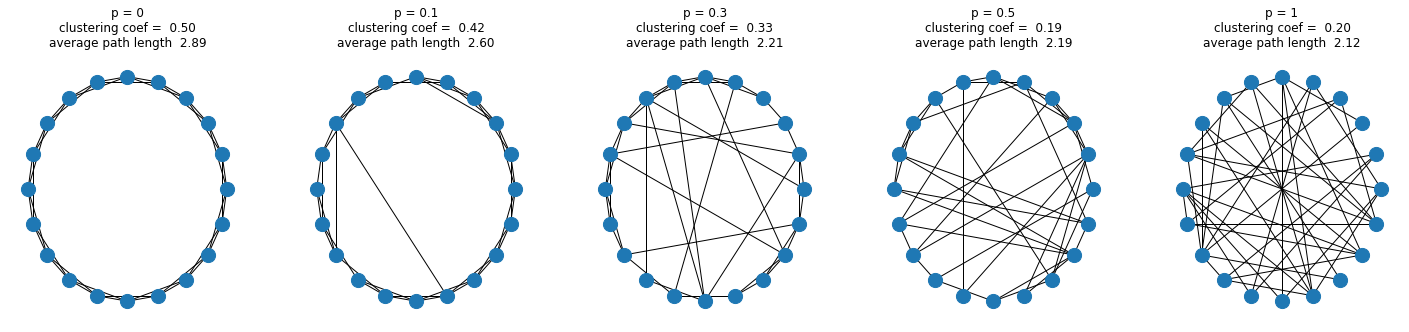

In [52]:
n = 20
k = 4
p = 0
plt.figure(figsize = (25, 5))
for i, p in enumerate([0, .1, .3, .5, 1]):
    G = nx.watts_strogatz_graph(n, k, p)
    plt.subplot(1, 5, i + 1)
    nx.draw_circular(G, node_size = 200)
    plt.title(f"{p = }\nclustering coef = {average_clustering(G): .2f}\naverage path length {nx.average_shortest_path_length(G): .2f}")

**Properties**
- the rewiring creates $p \cdot N \cdot K/2$ *long range* links
- For small $p$
	- Local properties are still the same as the original mesh network
- Average path length drops dramatically as $p$ rises

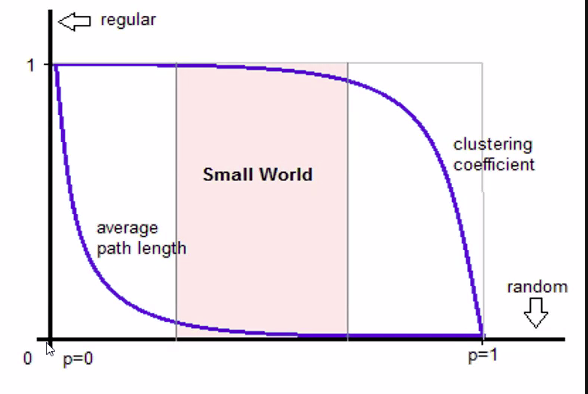

**Limitations - small worlds**
- SW are *homogenous* $\to$ all nodes have approx the same number of edges
	- Simlar to ER-random
- Newman watts
	- We don't delete links, we add new links with probability $p$
	- no 2-link, no self-links
	- if $p = 0 \approx$ original nearest neighbor
	- if $p = 1 \to$ fully connected network (not random as $WS$)

- No **preferential attachment**

# Scale free

Random $ER$ and $SW$ networks have a degree distribution with a *peak* at an *average value* that decays exponentially $\to$ **Exponential networks**

In reality we have a **power-law** distirbution $\to$ scale-free property

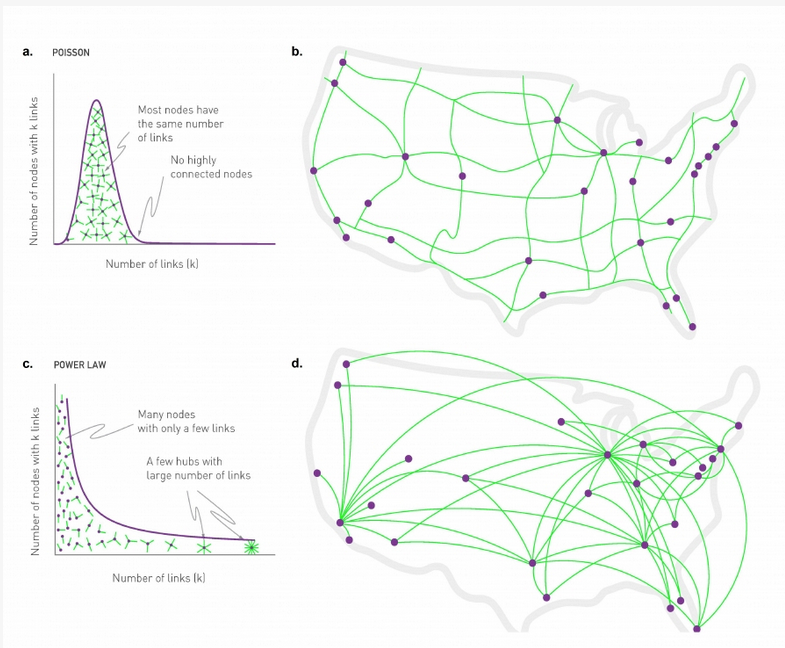

## Barabasi-albert model

**Construction**
1. Begin with an *Initial connected* network of $m_0$ nodes. 
2. At every iteration a new node added and connected to $m < m_0$ existing nodes
- The probability of wiring $p$ is proportial to the number of links that the existing nodes already have
$$\boxed{p_i = \dfrac {k_i} {\sum_j k_j}}$$

*Intuition*
- The probability is higher if that node has a higher degree $\to$ **Preference networks**
- Example: Higher chance to connect to celebrities

After $t$ iterations: 
$N = t + m_0$ nodes
$E =  m\cdot t$ edges

**Examples**
- Internet, Online communities (fb, twitter), genome, Airline networks


In [294]:
def attach(node, n, m, G):
    s = sum(G.degree(u) for u in G.nodes) 
    ps = [G.degree(u) / s for u in G.nodes] # probability distribution
    to_add = np.random.choice(node, p = ps, size = m, replace=False) # Choose nodes
    G.add_edges_from(zip([node] * m, to_add))


In [295]:
def barabasi_albert_graph(n, m, initial_graph = None):
    if initial_graph is None:
        G = nx.star_graph(m)
    else:
        assert len(initial_graph) >= m and len(initial_graph) <= n, f"initial_graph needs between {m} and {n} nodes"
        G = initial_graph.copy()
        
    for i in range(len(G), n):
        attach(i, n, m, G)
    return G
        

Graph with 20 nodes and 100 edges


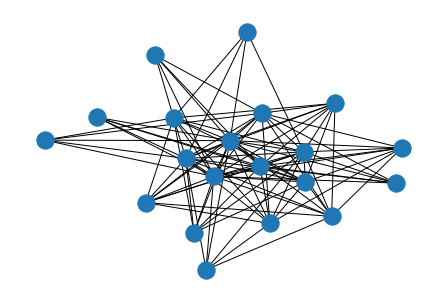

In [296]:
n = 20
m = 10
G = barabasi_albert_graph(n, m)
print(G)
nx.draw(G)

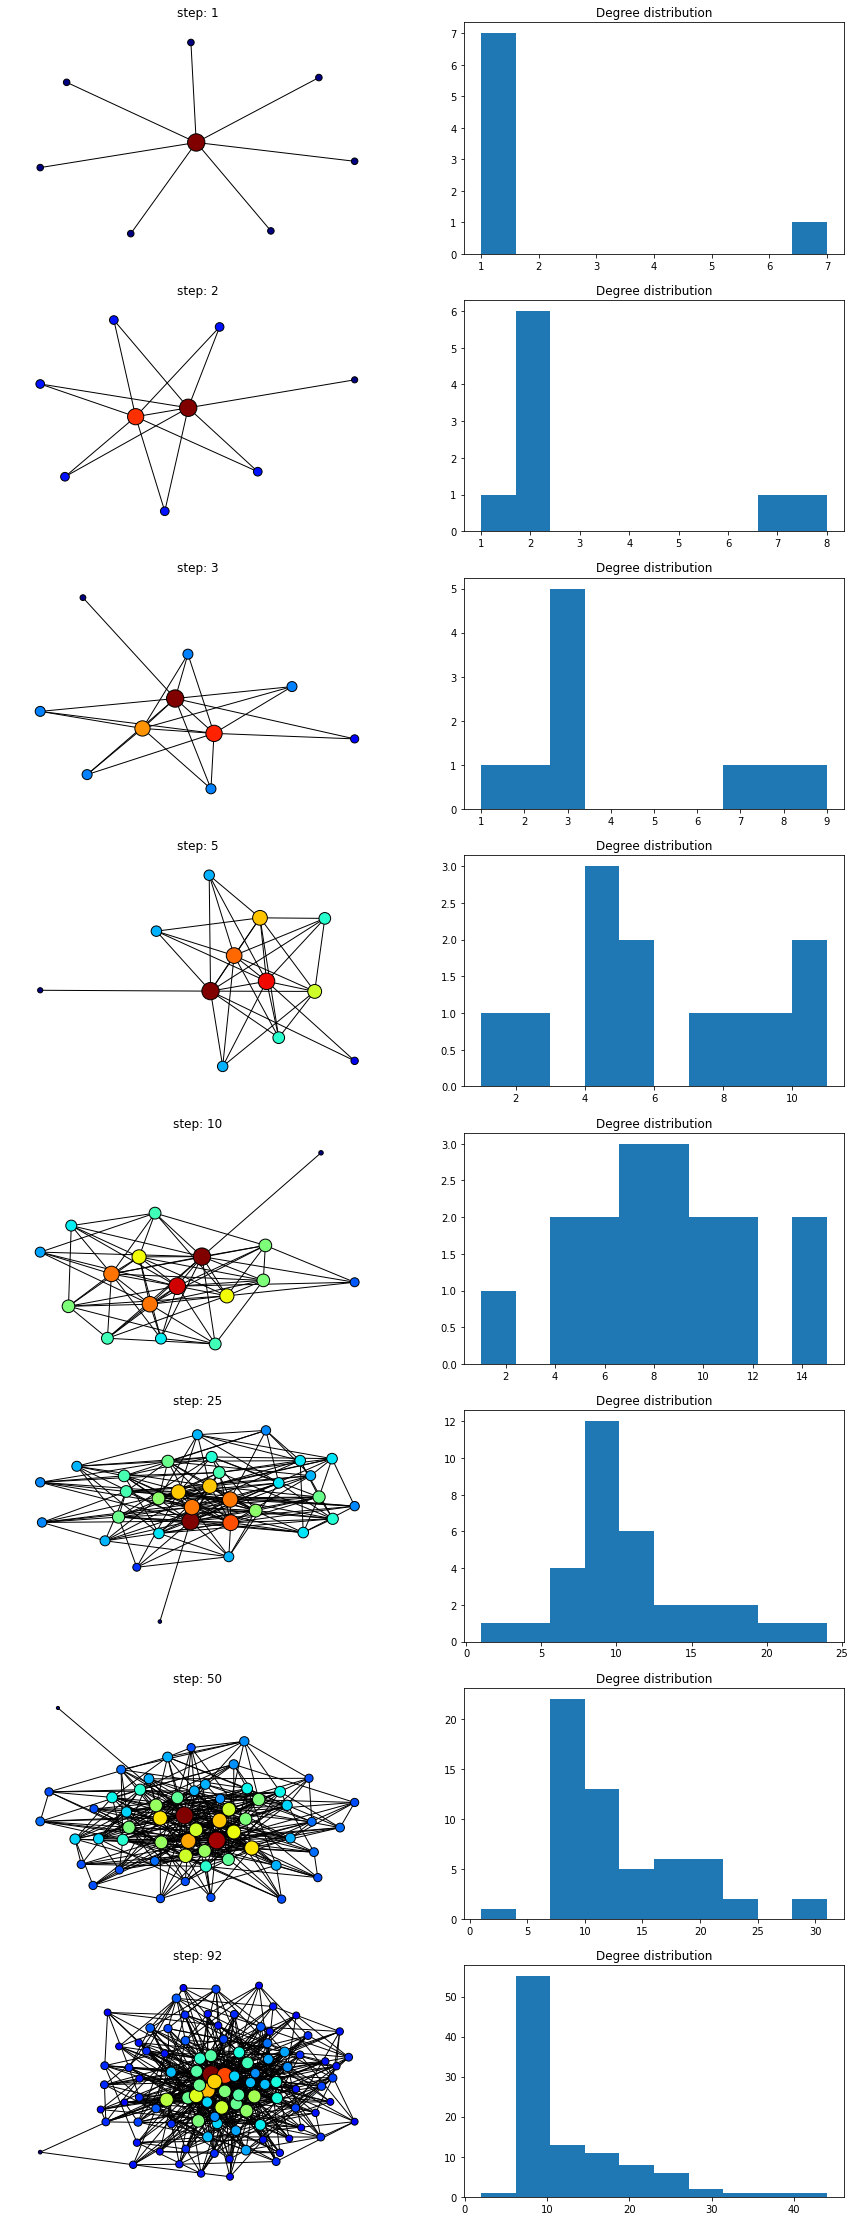

In [315]:
# Evolution:
n = 100
m = 7

G = nx.star_graph(m)
plot_steps = np.array([1, 2, 3, 5, 10, 25, 50, n-m-1])
plot_steps = plot_steps + m

i = 1
plt.figure(figsize = (15,  5 * 8))
for node in range(len(G), n):
    if node in plot_steps:
        # Plot graph
        plt.subplot(8, 2, i)
        sizes = np.array(list(nx.degree_centrality(G).values())) # Sizes and colors based on degree centrality
        sizes = sizes / max(sizes) * 300
        nx.draw_spring(G, node_size = sizes, edgecolors = 'black', node_color = sizes, cmap = plt.cm.jet)
        plt.title(f"step: {node - m}")
        i+=1
        # Plot degree distribution
        plt.subplot(8, 2, i)
        plt.title("Degree distribution")
        plt.hist([G.degree(u) for u in G.nodes])
        i+=1
    attach(node, n, m, G)

**Properties**
- Diameter $D \approx \dfrac {\log N} {\log \log N}$
- Avg path length $E = \dfrac {\ln N} {\ln \ln N}$
- Degree distribution $P(k) = k^{-3}$
- Clustering coef $C = \dfrac m 8 \cdot \dfrac {(\ln N)^2} N \approx N^{-0.75}$

In [326]:
n = 1000
m = 10
G = barabasi_albert_graph(n, m)
print(G)

Graph with 1000 nodes and 9900 edges


In [327]:
print(nx.diameter(G), np.log(n) / np.log(np.log(n)))
print(f"{average_clustering(G) = : .4f} == {m / 8 * np.log(n) ** 2 / n = :.4f}")

4 3.574249916581999
average_clustering(G) =  0.0623 == m / 8 * np.log(n) ** 2 / n = 0.0596


**Limitations - scale free**  
Does not capture 
- Variations in the shape of degree distribution (**linear** growth)
- Variations in the degree exponent (**linear** preferential attachement)
- Size independent clustering coeff
- First nodes have advantage (later nodes can't catch up) $\to$ not real

- No high levels of clustering

# Kronecker graph

- https://www.youtube.com/watch?v=Xnpt8US31cQ&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&index=44